# Studying contamintation of other final states

In [54]:
import uproot
from pathlib import Path
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)
import matplotlib.ticker as mtick

In [110]:
def load(f):
    if isinstance(f, str): f = [f]
    ars = []
    sum_genw = 0.
    base_entry_count = 0
    for path in f:
        with uproot.open(path) as rf:
            ars.append(rf["Events"].arrays(filter_name=["genWeight", "LHE_*", "LHEPart*", "GenPart_*", "Ztt_*", "Xtt_*", "Zbb_*", "ZZ_*", "fatjet_pt_smeared", "fatjet_hadron*", "bjet*_hadronFlavour", "bjet*_pt*", "pairType*", "dau*_pt", "dau*_genPartFlav",
                                                            "pairType*", "isBoostedTau", "jetCategory"], how="zip"))
            sum_genw += rf["sum_genw"].values()[0]
            base_entry_count += rf["sum_genw"].all_members["fEntries"]
    return dict(ar=ak.concatenate(ars), sum_genw=sum_genw, base_entry_count=base_entry_count)

In [45]:
res = load("/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/wminush_hbb_wqq/cat_base_selection/prod_250315_withCatVars/data_0.root")
ar = res["ar"]
ar

<Array [{LHE_AlphaS: 0.247, ...}, ..., {...}] type='257 * {LHE_AlphaS: floa...'>

In [ ]:
def elliptical_cut(ar, tt_center, tt_width, bb_center, bb_width):
    return np.square(ar.Xtt_svfit_mass - tt_center) / (tt_width**2) + np.square(ar.Zbb_mass_smeared - bb_center) / (bb_width**2) <1
def EC_ZZ(ar):
    return elliptical_cut(ar, 95., 120., 85., 165.5)
def EC_ZbbHtt(ar):
    return elliptical_cut(ar, 125., 100., 85., 131.5)
def EC_ZttHbb(ar):
    return elliptical_cut(ar, 85., 92., 115., 130.0)
def total_EC(ar):
    return EC_ZZ(ar) | EC_ZbbHtt(ar) | EC_ZttHbb(ar)
def make_category(ar):
    return ak.with_field(ar, ak.where(ar.isBoostedTau & (ar.jetCategory == 2), 3, ar.jetCategory), "categoryPlot")

In [142]:

arf = make_category(ar[total_EC(ar)])
def make_h():
    return hist.new.Integer(0, 4, name="category", label="Category").Integer(0, 3, name="pairType", label="Channel").Weight()
def make_plot(h, label, short_label, xs=None, ax=None):
    if not ax: _, ax = plt.subplots()
    x = hep.hist2dplot(h, flow=False, ax=ax)
    ax.set_xticklabels(["Resolved 2b", "Resolved 1b", "Boosted-bb\n(HPS)", "Boosted Taus"])
    ax.set_yticklabels([r"$\tau_\mu\tau_h$", r"$\tau_e\tau_h$", r"$\tau_h\tau_h$"])
    x.cbar.set_label(f"{short_label} expected / "r"$Z_{bb}Z_{\tau\tau}$ expected")
    #x.cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    hep.cms.label("Preliminary", year=2018)
    if xs: label += "\n"r"$\sigma = " f"{xs:.3f}" "pb$"
    plt.text(0.95, 0.95, label, transform=ax.transAxes, ha="right", va="top", color="white")
labels = {
    "wminush_hbb_wqq" : r"$W^-H$""\n"r"$(H\to bb, W^-\to qq)$",
    "wminush_hbb_wlnu": r"$W^-H$""\n"r"$(H\to bb, W^-\to l\nu)$",
    "ggHH_bbVV": r"$gg\to HH\to bbVV$""\n"r"$(VV\to 4q)$",
    "wminush_htt": r"$W^-H$""\n"r"$(H\to \tau\tau)$",
    "ggf_sm": r"$gg\to HH \to bb\tau\tau$",
    "zz_sl_signal" : r"$pp\to ZZ \to bb\tau\tau$"
}
short_labels = {"wminush_hbb_wqq" : r"$W^-H(bbqq)$",
    "wminush_hbb_wlnu": r"$W^-H(bbl\nu)$",
    "ggHH_bbVV": r"$HH(bbqqqq)$",
    "wminush_htt": r"$W^-H_{\tau\tau}$",
    "ggf_sm": r"$HH(bb\tau\tau)$",
    "zz_sl_signal" : r"$ZZ(bb\tau\tau)$"}
xs = {    "ggHH_bbVV" : 0.0017 , # (XSDB says 0.02669) 
    "wminush_hbb_wlnu" : 0.103,
    "wminush_hbb_wqq" : 0.3675*0.58,
    "wminush_htt":      0.5412,  
    "ggf_sm":0.002268,
    "zz_sl_signal":  0.172,
    }
def load_h(dataset):
    if dataset == "wminush_htt":
        res = load([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/{dataset}/cat_base_selection/prod_250315_withCatVars/data_{i}.root" for i in range(6)])
    else:
        res = load(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/{dataset}/cat_base_selection/prod_250315_withCatVars/data_0.root")
    ar = res["ar"]
    arf = make_category(ar[total_EC(ar)])
    return make_h().fill(arf.categoryPlot, arf.pairType, weight=arf.genWeight/res["sum_genw"])
    #make_plot(arf, labels.get(dataset, dataset), xs=xs.get(dataset, None))

def make_all_ratio(dataset, zz_h, ax=None):
    h = load_h(dataset)
    h_ratio = make_h()
    h_ratio.view(True).value = h.values(True) / zz_h.values(True) * xs[dataset] / xs["zz_sl_signal"]
    make_plot(h_ratio, labels.get(dataset, dataset), short_labels.get(dataset, dataset), xs=xs.get(dataset, None), ax=ax)


In [143]:
# reference histogram : ZZ
zz_h = load_h("zz_sl_signal")
zz_h

Hist(
  Integer(0, 4, name='category', label='Category'),
  Integer(0, 3, name='pairType', label='Channel'),
  storage=Weight()) # Sum: WeightedSum(value=0.0127665, variance=1.70618e-07) (WeightedSum(value=0.186498, variance=2.28073e-06) with flow)

/tmp/ipykernel_2327355/1631542542.py:48: RuntimeWarning: invalid value encountered in divide
  h_ratio.view(True).value = h.values(True) / zz_h.values(True) * xs[dataset] / xs["zz_sl_signal"]
/tmp/ipykernel_2327355/1631542542.py:48: RuntimeWarning: invalid value encountered in divide
  h_ratio.view(True).value = h.values(True) / zz_h.values(True) * xs[dataset] / xs["zz_sl_signal"]
/tmp/ipykernel_2327355/1631542542.py:48: RuntimeWarning: invalid value encountered in divide
  h_ratio.view(True).value = h.values(True) / zz_h.values(True) * xs[dataset] / xs["zz_sl_signal"]
/tmp/ipykernel_2327355/1631542542.py:48: RuntimeWarning: invalid value encountered in divide
  h_ratio.view(True).value = h.values(True) / zz_h.values(True) * xs[dataset] / xs["zz_sl_signal"]
/tmp/ipykernel_2327355/1631542542.py:48: RuntimeWarning: invalid value encountered in divide
  h_ratio.view(True).value = h.values(True) / zz_h.values(True) * xs[dataset] / xs["zz_sl_signal"]
/tmp/ipykernel_2327355/1631542542.py:48:

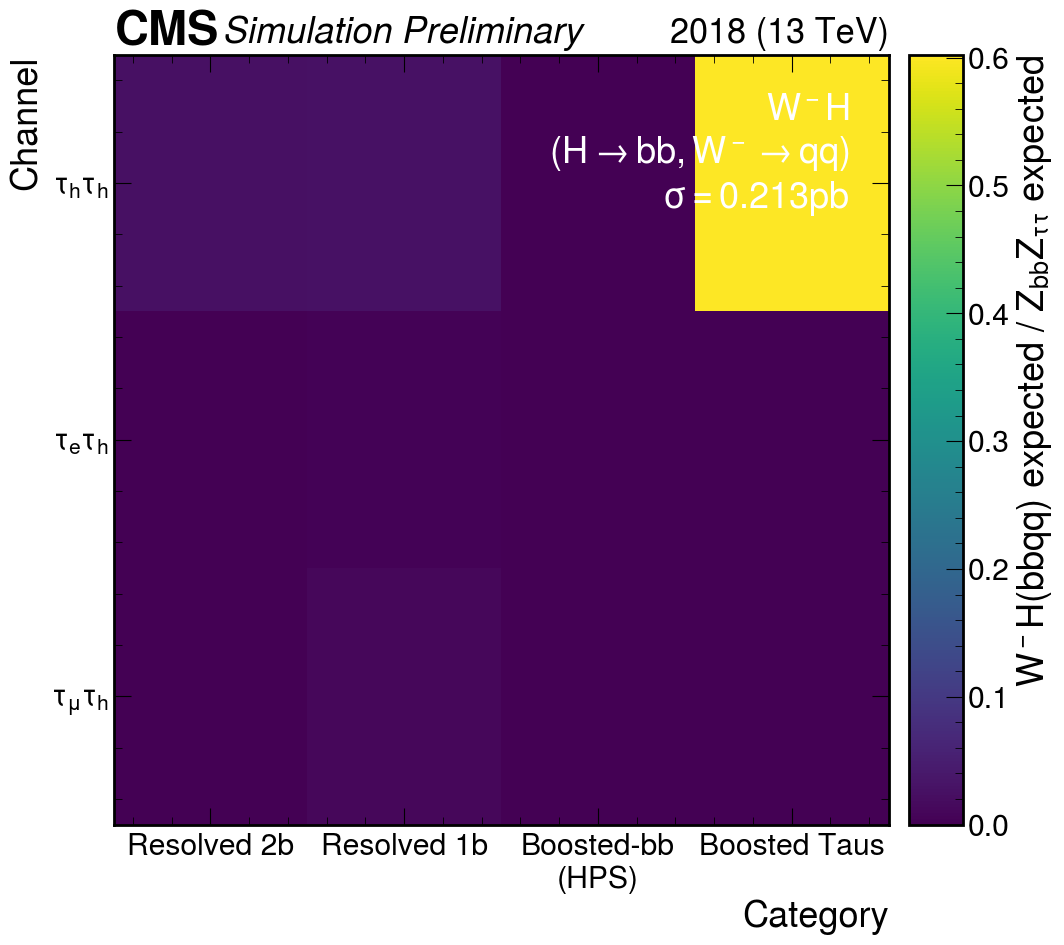

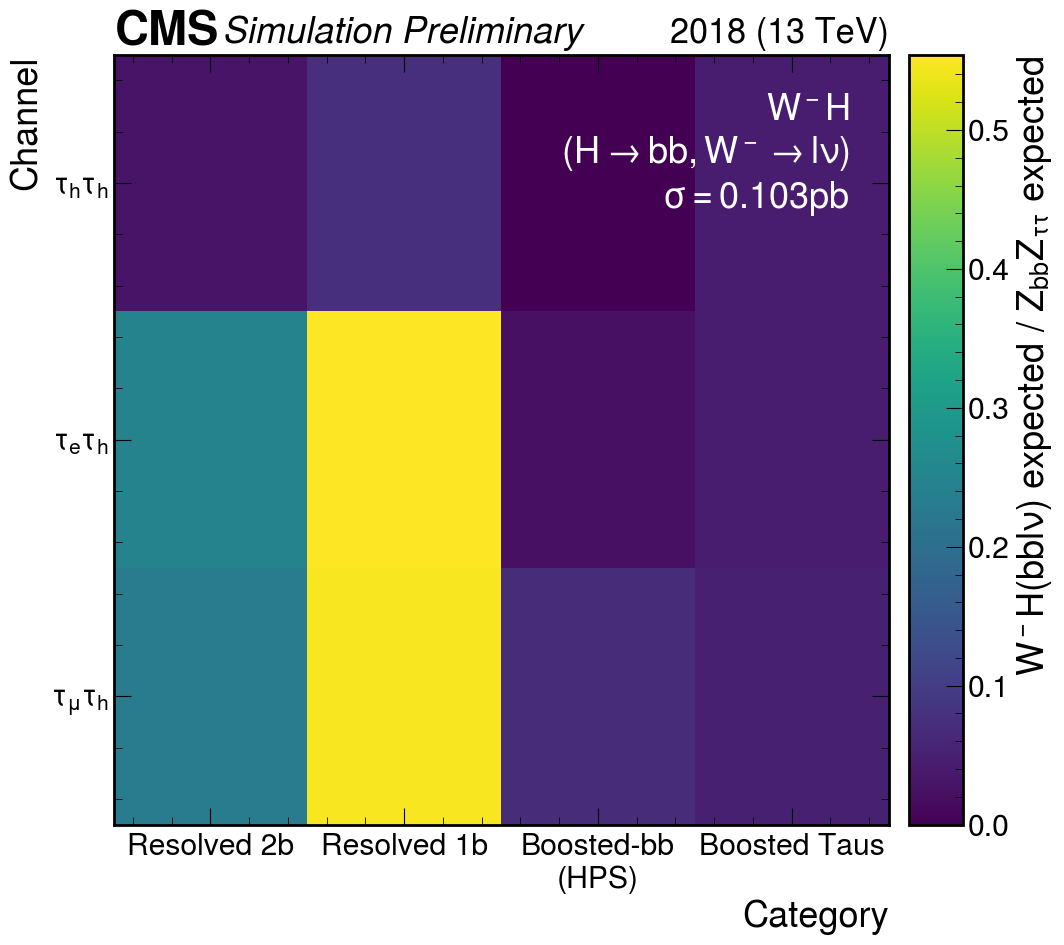

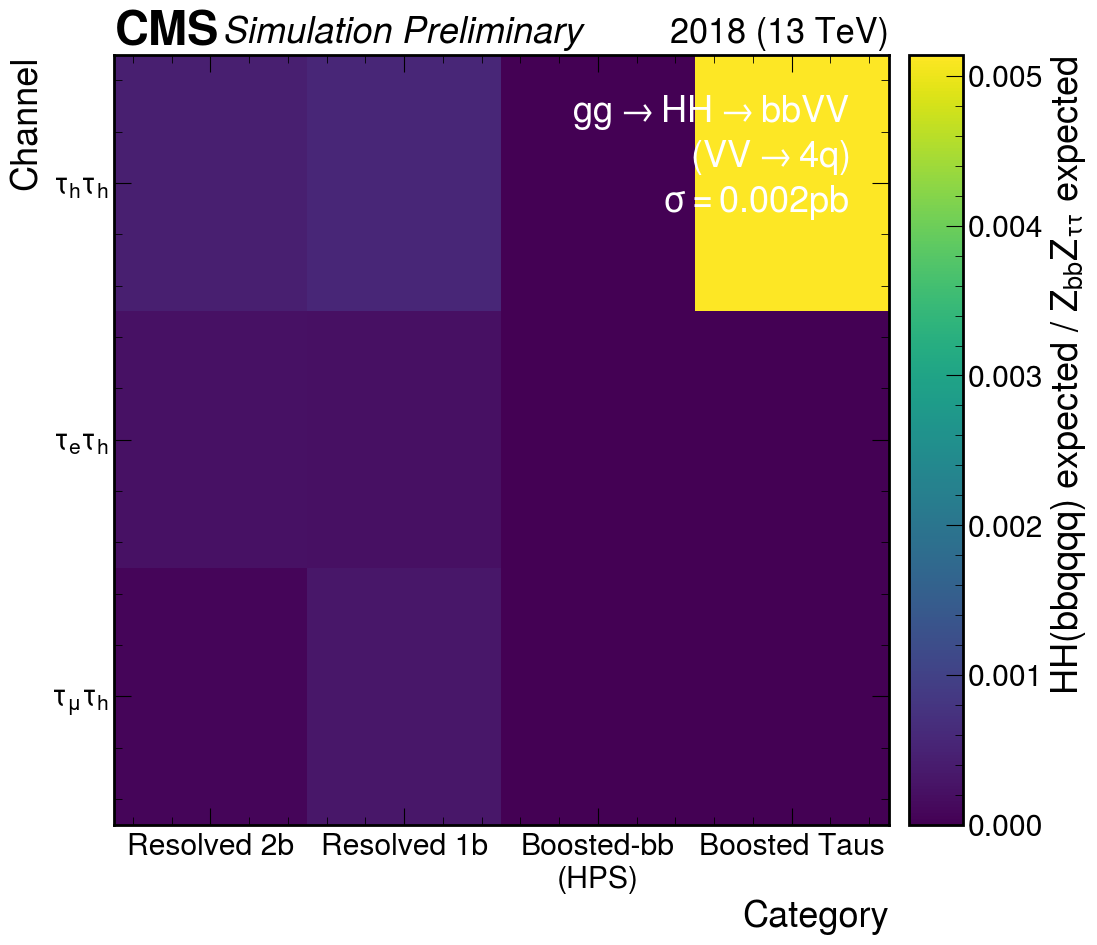

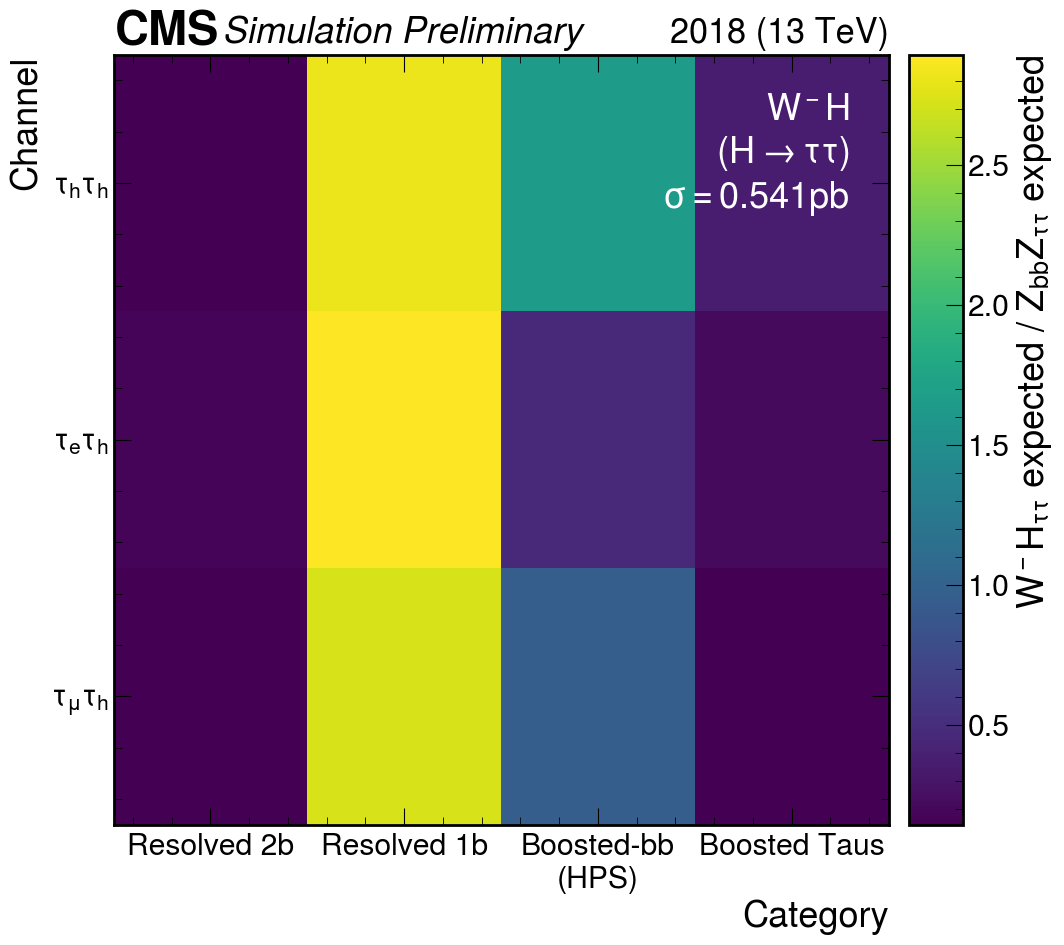

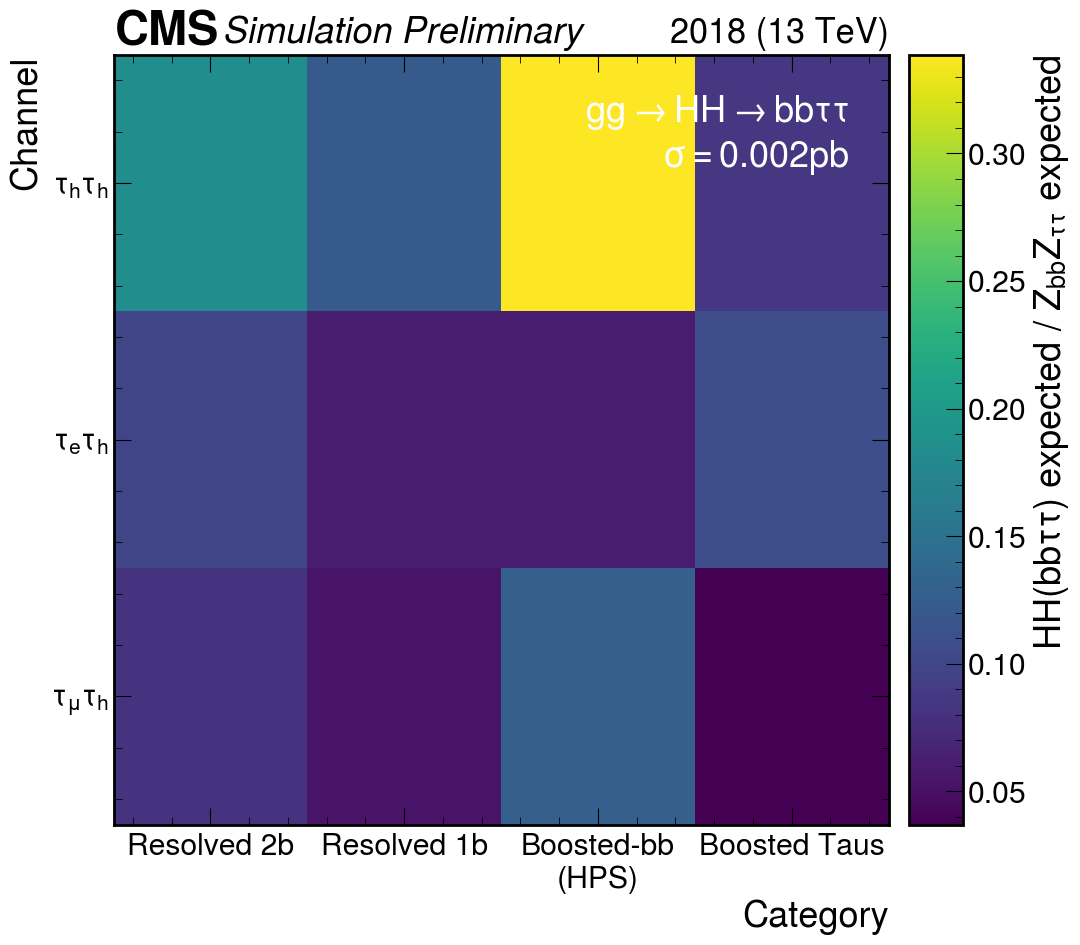

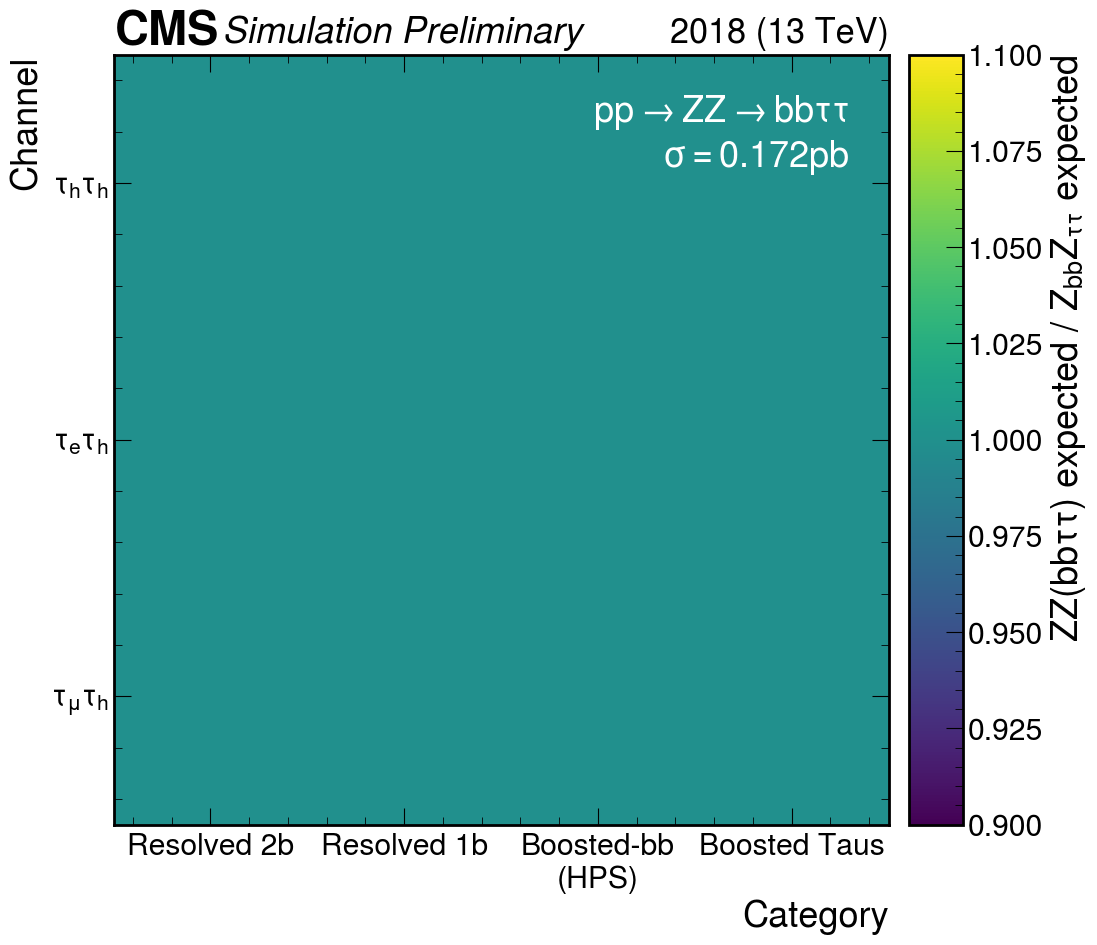

In [147]:
# fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# axs = axs.flatten()
for dataset, in zip(labels,):
    make_all_ratio(dataset, zz_h, ax=None)
    plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/contaminationOtherFS/{dataset}.pdf", bbox_inches="tight")
    plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/contaminationOtherFS/{dataset}.png", bbox_inches="tight")

In [ ]:
# how many evts of WH / how many evts of ZZ
# WH genw / sumgenw(WH) * xs(WH)  / (ZZ sumgenw / sumgewn(ZZ) * xs(ZZ))

In [118]:
res_zz = load(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/zz_sl_signal/cat_base_selection/prod_250315_withCatVars/data_0.root")
res_zz

{'ar': <Array [{LHE_AlphaS: 0.0905, ...}, ..., {...}] type='43081 * {LHE_AlphaS: f...'>,
 'sum_genw': 1164948.9629421234,
 'base_entry_count': 216547.0}

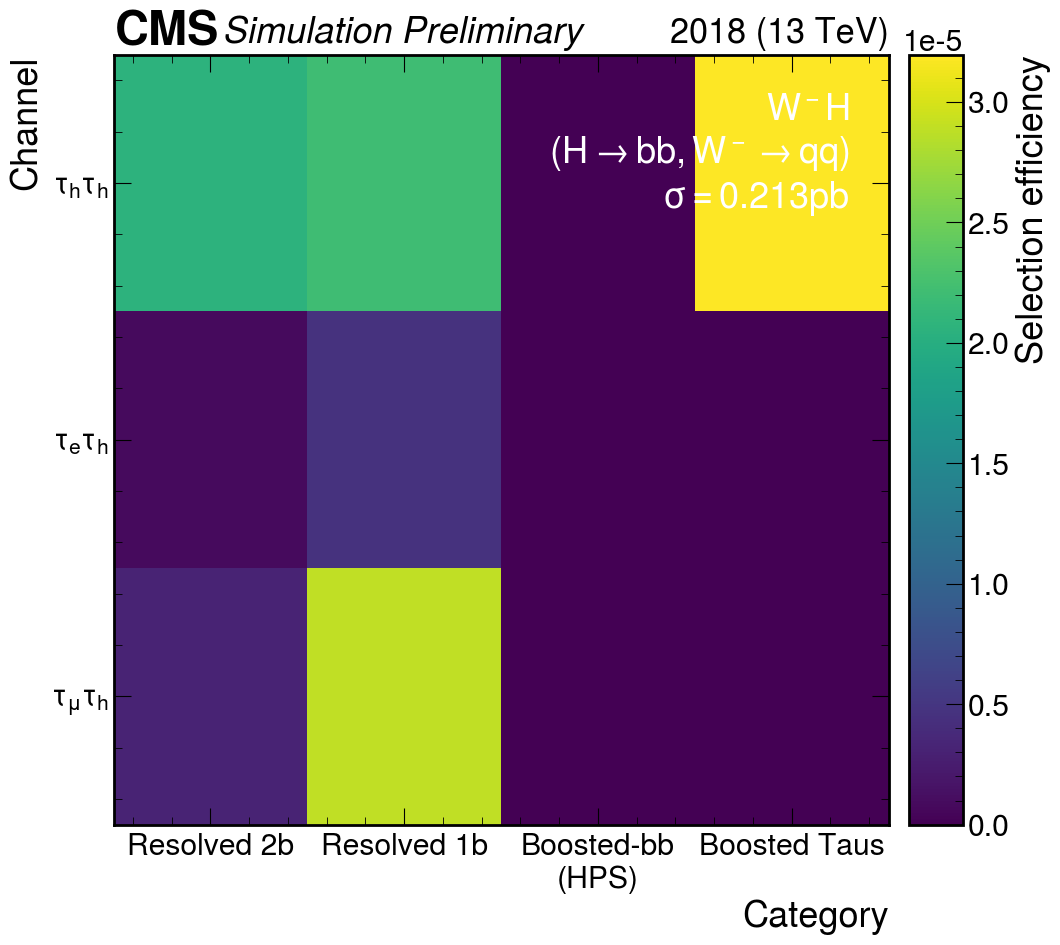

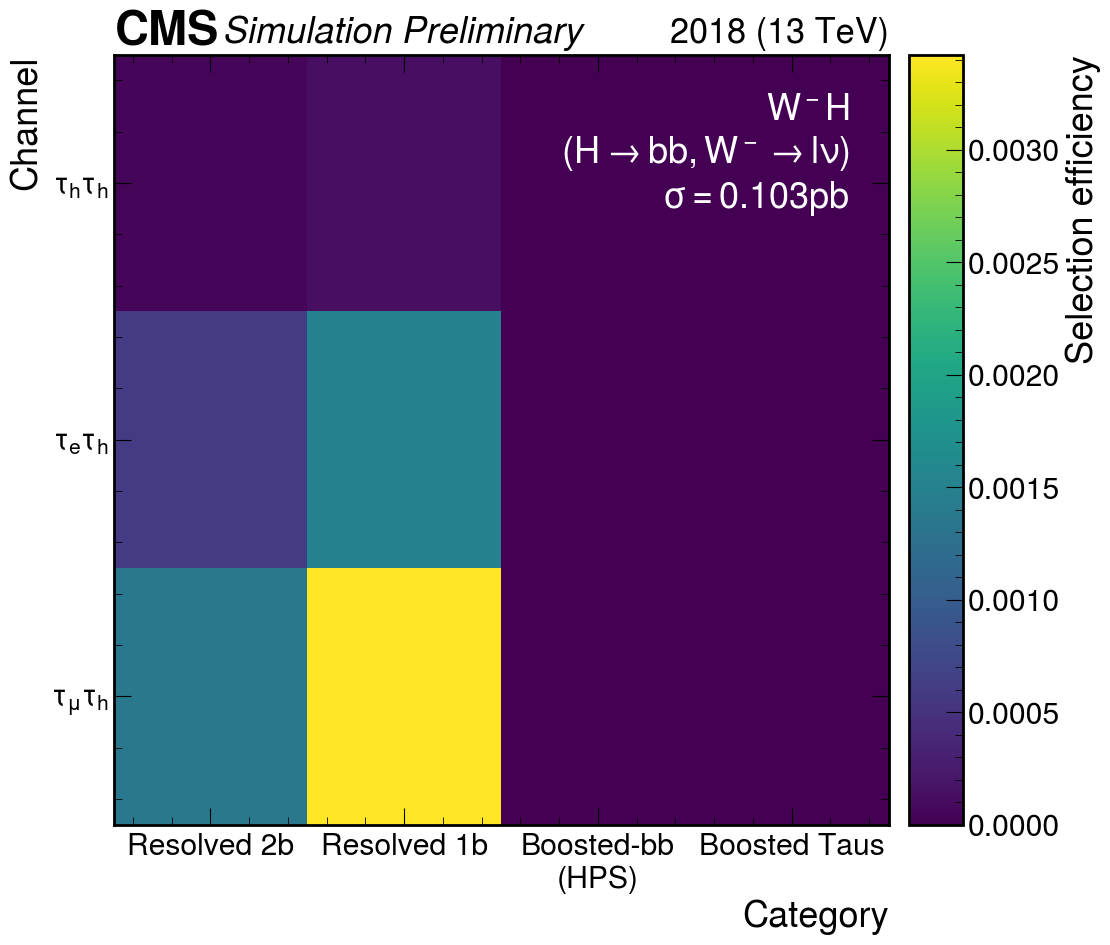

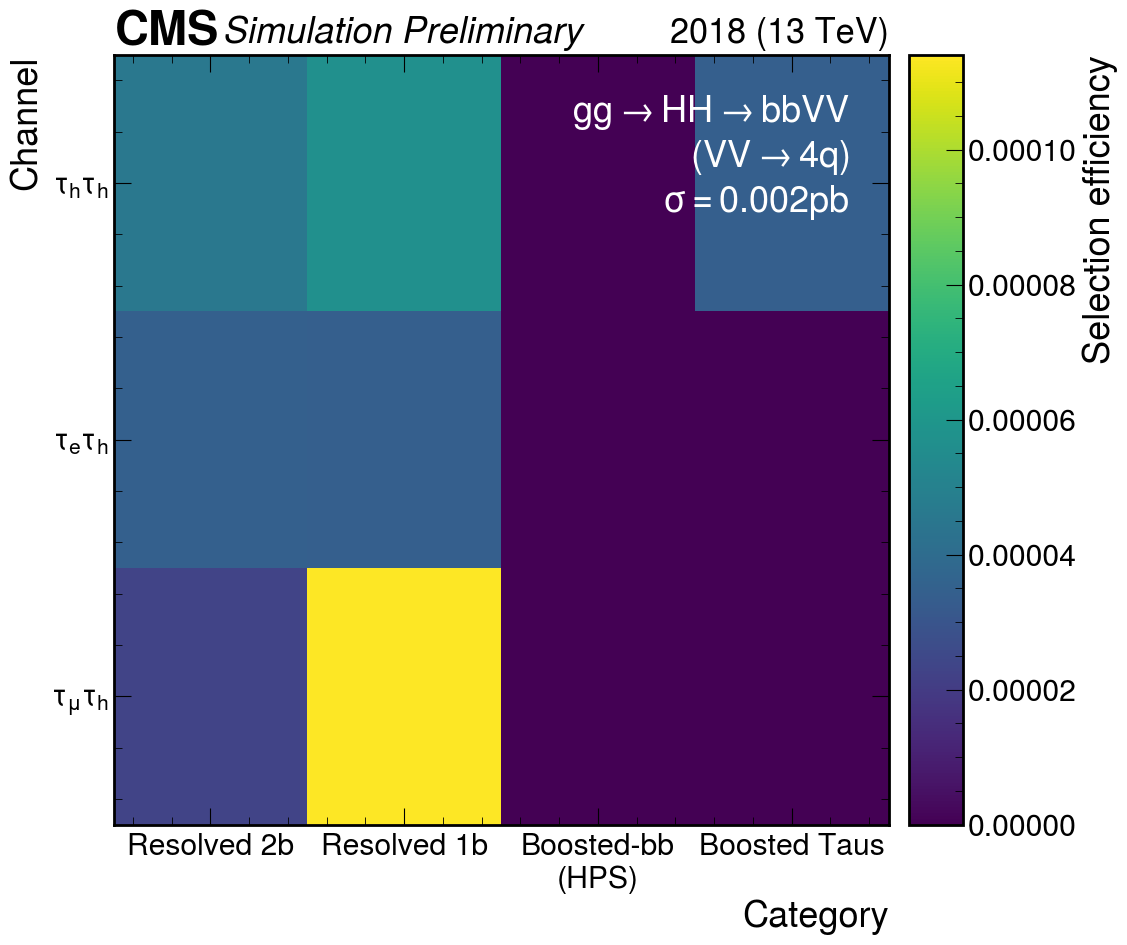

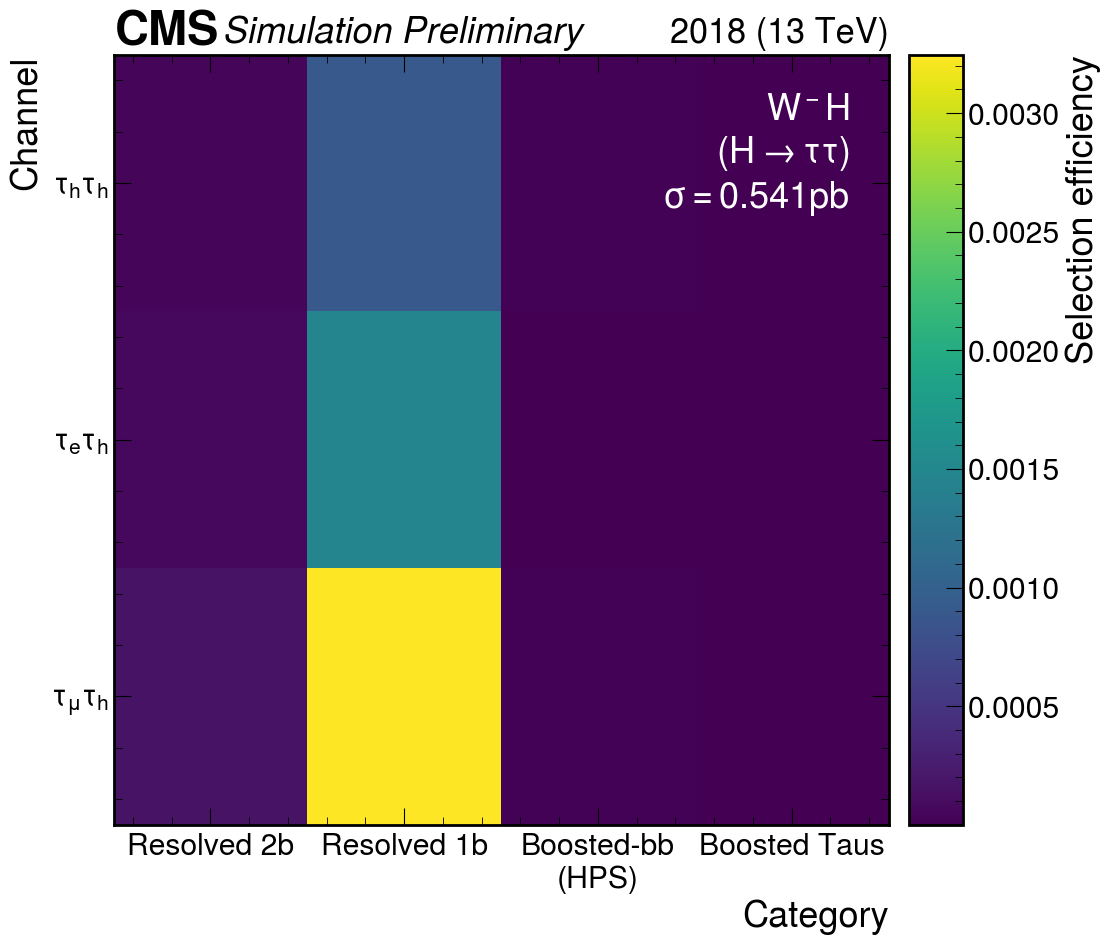

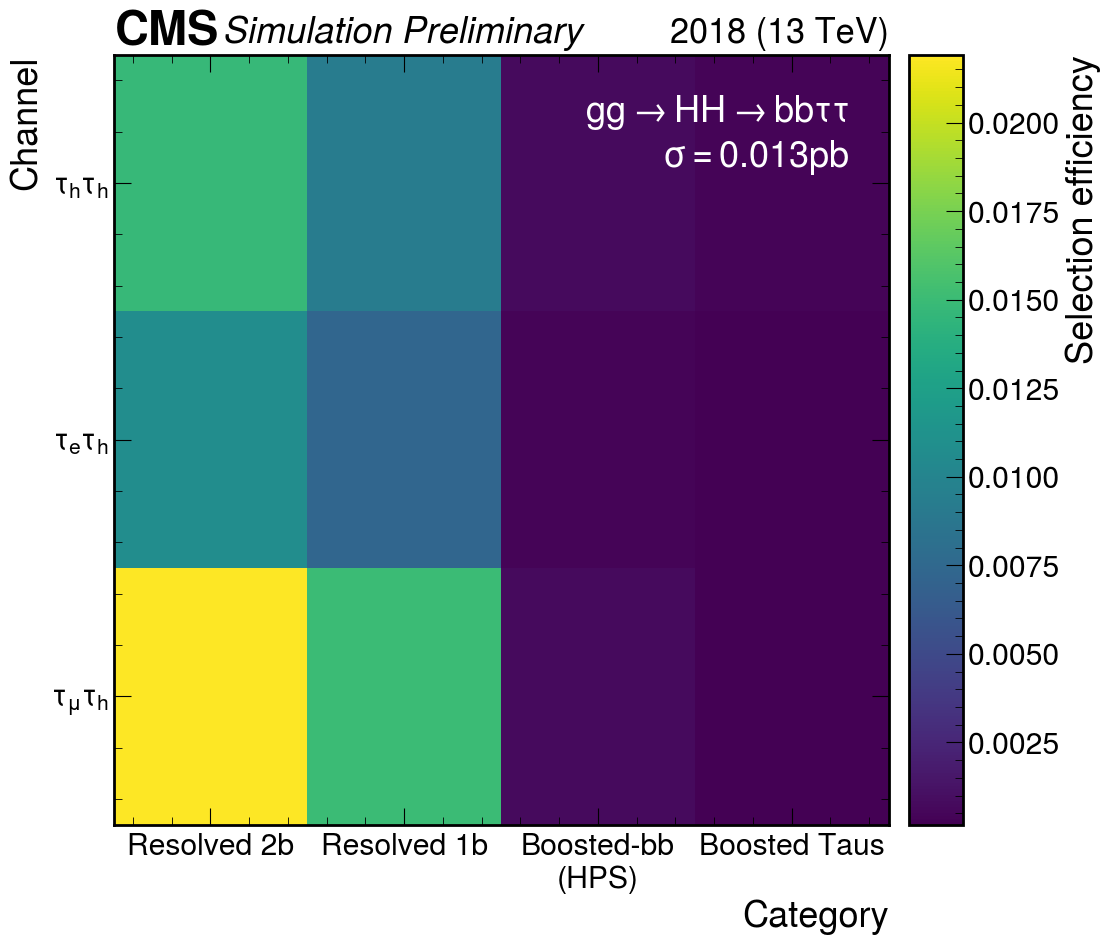

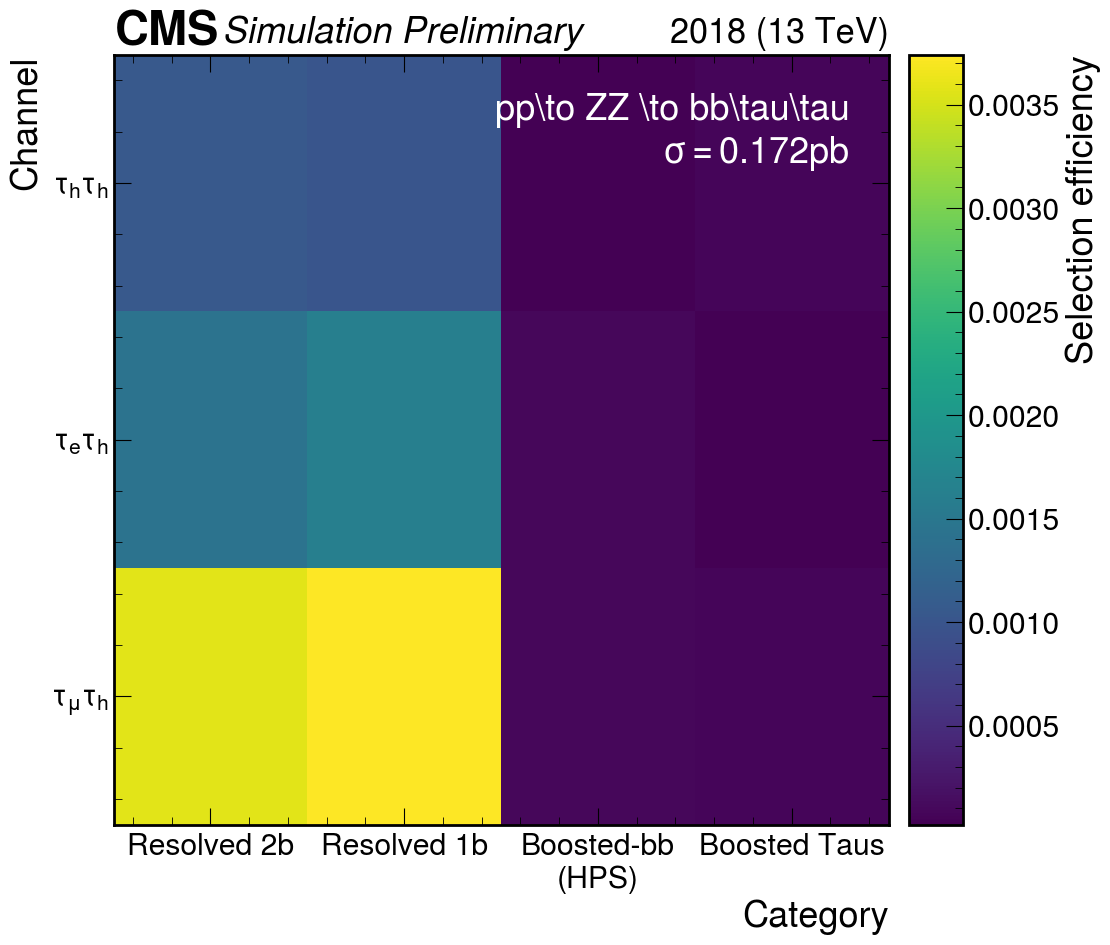

In [119]:
for dataset in labels:
    make_all(dataset)